In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


2025-05-15 21:32:38.175346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 21:32:38.404540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747369958.472931   79243 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747369958.499480   79243 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747369958.673156   79243 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
image_size = (256, 256) 
batch_size = 32 
train_dir = 'ML Project/../input/brain-tumor-classification-mri/Training' 
test_dir = 'ML Project/../input/brain-tumor-classification-mri/Testing' 


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1), 
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1)
])


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred', # detect classes from input folder
    label_mode='categorical', # One-hot encoding
    image_size=image_size, # Resize images
    interpolation='bicubic', # Resize method
    batch_size=batch_size,
    validation_split=0.1,
    subset='training',
    seed=123,
    shuffle=True # Shuffle the data
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred', # detect classes from input folder
    label_mode='categorical', # One-hot encoding
    image_size=image_size, # Resize images
    interpolation='bicubic', # Resize method
    batch_size=batch_size,
    validation_split=0.1,
    subset='validation',
    seed=123,
    shuffle=True # Shuffle the data
)

#Apply data_augmentation to images
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(preprocess_input(x)), y), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)


test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='bicubic',
    batch_size=batch_size,
    shuffle=False 
)

test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Optimize loading the dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)



I0000 00:00:1747369963.002582   79243 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 2870 files belonging to 4 classes.
Using 2583 files for training.
Found 2870 files belonging to 4 classes.
Using 287 files for validation.
Found 394 files belonging to 4 classes.


In [3]:
#Arrays to store training data (numerical values)
X_train_list = []
y_train_list = []


for image_batch, label_batch in train_dataset:
  X_train_list.append(image_batch.numpy()) 
  y_train_list.append(label_batch.numpy()) 

#Conver to np arrays
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

X_validation_list = []
y_validation_list = []

for image_batch, label_batch in validation_dataset:
  X_validation_list.append(image_batch.numpy()) 
  y_validation_list.append(label_batch.numpy()) 

X_validation = np.concatenate(X_validation_list, axis=0)
y_validation = np.concatenate(y_validation_list, axis=0)

#Conver to np arrays
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

#Same as for testing data
X_test_list = []
y_test_list = []


for image_batch, label_batch in test_dataset:
  X_test_list.append(image_batch.numpy())
  y_test_list.append(label_batch.numpy())


X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_validation shape: ", X_validation.shape)
print("y_validation shape", y_validation.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



2025-05-15 21:32:48.083150: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-15 21:32:49.820030: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train shape: (2583, 256, 256, 3)
y_train shape: (2583, 4)
X_validation shape:  (287, 256, 256, 3)
y_validation shape (287, 4)
X_test shape: (394, 256, 256, 3)
y_test shape: (394, 4)


In [4]:
#Transfer learning with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

#Freeze all layers
base_model.trainable = False

In [5]:
#Build the CNN model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax'),
])

#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_validation, y_validation))

Epoch 1/20


I0000 00:00:1747369999.735171   79562 service.cc:152] XLA service 0x7ff7c0002ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747369999.735816   79562 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-15 21:33:19.918379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747370001.096459   79562 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-15 21:33:22.223297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5310', 204 bytes spill stores, 204 bytes spill loads

2025-05-15 21:33:22.368406: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_531

 2/81 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.1875 - loss: 2.1053  

I0000 00:00:1747370007.337046   79562 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5503 - loss: 1.1890

2025-05-15 21:33:34.278991: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5310', 236 bytes spill stores, 236 bytes spill loads

2025-05-15 21:33:34.366849: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8172', 20 bytes spill stores, 20 bytes spill loads

2025-05-15 21:33:34.553661: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5310', 4388 bytes spill stores, 4232 bytes spill loads

2025-05-15 21:33:34.644705: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5310', 1012 bytes spill stores, 1012 bytes spill loads

2025-05-15 21:33:34.707014: I 

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5519 - loss: 1.1845

2025-05-15 21:33:40.761267: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1731', 4 bytes spill stores, 4 bytes spill loads

2025-05-15 21:33:43.627813: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 236 bytes spill stores, 236 bytes spill loads

2025-05-15 21:33:43.885362: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 4388 bytes spill stores, 4232 bytes spill loads

2025-05-15 21:33:43.966301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 1012 bytes spill stores, 1012 bytes spill loads



81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 247ms/step - accuracy: 0.5535 - loss: 1.1801 - val_accuracy: 0.8537 - val_loss: 0.4525
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8402 - loss: 0.4365 - val_accuracy: 0.8641 - val_loss: 0.3424
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8669 - loss: 0.3526 - val_accuracy: 0.8118 - val_loss: 0.4011
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8846 - loss: 0.3181 - val_accuracy: 0.8467 - val_loss: 0.3308
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9079 - loss: 0.2527 - val_accuracy: 0.8990 - val_loss: 0.2771
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9095 - loss: 0.2489 - val_accuracy: 0.9059 - val_loss: 0.2643
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9209 - loss: 0.2193 - val_accuracy: 0.8815 - val_loss: 0.3152
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9269 - loss: 0.2018 - val_accuracy: 0.9094 - val_loss: 

In [7]:
#Fine-tuning the pre-trained model
base_model.trainable = True

#Freeze only 30 last layers of the pre-trained model
for layer in base_model.layers[:-30]:
    layer.trainable = False

#Recompile the main model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#For callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint('effnet.h5', monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 3, min_delta = 0.001,
                              min_lr=1e-6, mode='auto',verbose=1)

#Train the model with callbacks
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_validation, y_validation), callbacks=[tensorboard,checkpoint,reduce_lr, early_stop])

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8604 - loss: 0.4713
Epoch 1: val_accuracy improved from -inf to 0.86063, saving model to effnet.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 243ms/step - accuracy: 0.8609 - loss: 0.4694 - val_accuracy: 0.8606 - val_loss: 0.5499 - learning_rate: 1.0000e-04
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9730 - loss: 0.0924
Epoch 2: val_accuracy improved from 0.86063 to 0.92683, saving model to effnet.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.9730 - loss: 0.0922 - val_accuracy: 0.9268 - val_loss: 0.2155 - learning_rate: 1.0000e-04
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9947 - loss: 0.0182
Epoch 3: val_accuracy improved from 0.92683 to 0.93728, saving model to effnet.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.9947 - loss: 0.0182 - val_accuracy: 0.9373 - val_loss: 0.2766 - learning_rate: 1.0000e-04
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9987 - loss: 0.0076
Epoch 4: val_accuracy did not improve from 0.93728
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9986 - loss: 0.0076 - val_accuracy: 0.9303 - val_loss: 0.2384 - learning_rate: 1.0000e-04
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9990 - loss: 0.0057
Epoch 5: val_accuracy did not improve from 0.93728
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9990 - loss: 0.0058 - val_accuracy: 0.9268 - val_loss: 0.2815 - learning_rate: 1.0000e-04
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9951 - loss: 0.0205
Epoch 6: val_accuracy did not improve from 0.93728

Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9951 - loss: 0.0205 - val_a

In [8]:
from sklearn.metrics import classification_report
#Perfrom prediction
y_pred = model.predict(X_test)

#Convert the highest probability to corresponding class label (index)
y_test_label = np.argmax(y_test, axis=1)
y_pred_label = np.argmax(y_pred, axis=1)

class_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

#Compare to true labels
print(classification_report(y_test_label, y_pred_label, target_names=class_labels))

#Report accuracy and 
loss, accuracy = model.evaluate(X_test, y_test, verbose = 2)
print("Accuracy: ", accuracy)
print("Loss: ", loss)


12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

2025-05-15 21:38:03.837208: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1679', 12 bytes spill stores, 12 bytes spill loads

2025-05-15 21:38:03.984206: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1686', 12 bytes spill stores, 12 bytes spill loads

2025-05-15 21:38:04.032252: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1679', 104 bytes spill stores, 104 bytes spill loads

2025-05-15 21:38:04.518403: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1679', 4044 bytes spill stores, 4024 bytes spill loads

2025-05-15 21:38:04.615069: I exte

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.39      0.56       100
  meningioma       0.68      0.96      0.79       115
    no_tumor       0.78      0.97      0.87       105
   pituitary       0.98      0.82      0.90        74

    accuracy                           0.79       394
   macro avg       0.86      0.79      0.78       394
weighted avg       0.84      0.79      0.77       394

13/13 - 2s - 154ms/step - accuracy: 0.7919 - loss: 2.0303
Accuracy:  0.7918781638145447
Loss:  2.0303142070770264


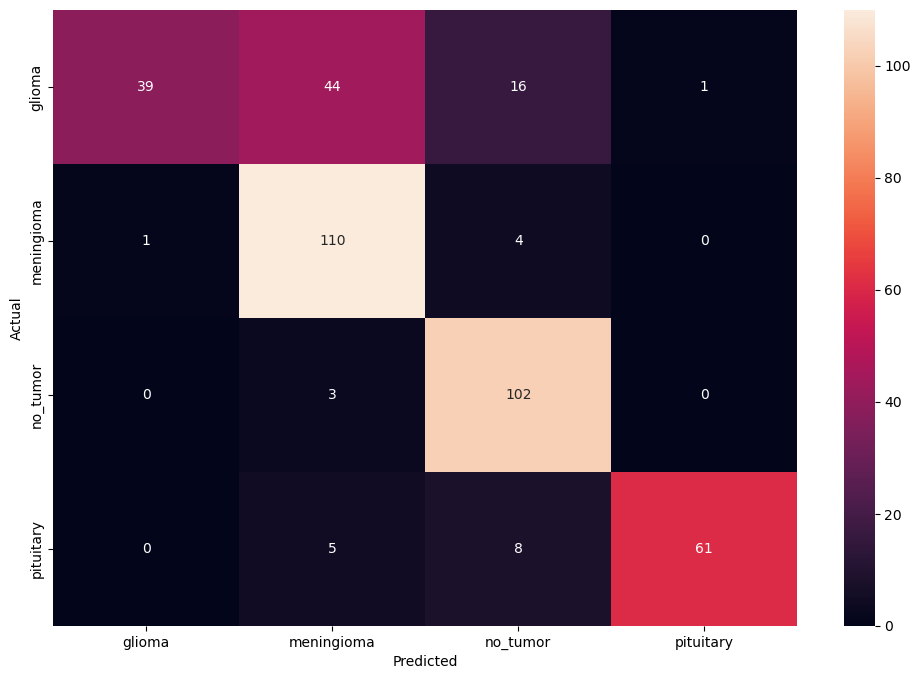

In [9]:
#Show confustion matrix

plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test_label, y_pred_label)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()